### Alex Jocius
### https://github.com/aajocius/CSPB3202-Final-Project.git
# Optimizing Q-Learning in Stochastic Environment

## Project Overview & Approach

In this project, I will attempt to investigate and optimize the Q-Learning algorithm learned over the semester.  I will utilize an OpenAI Gym environment to simualte the agent / environment interaction and attempt to manipulate hyperparamters to achieve the largest success rate for a stochastic environment.  

The evironment chosen for this project is OpenAI Gym's "Frozen Lake".  This environment consists of an agent attempting to cross a frozen lake to reach the Goal state without slipping and falling into holes spread across the environment.  The observation can be adjusted from a "4x4" grid to an "8x8" grid, including making custom layouts to test with. The environment can be set to slippery or nonslippery, with the slippery producing a stochastic environment where the agent's success of action is defined by a set probability distribution.  I will initially test and tune parameters on the slippery "4x4" grid, and will then test the implementation on the larger one.

In [1]:
import gym
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import clear_output
import time

The agent and evironment can be shown by utilizing the API's render function.

0


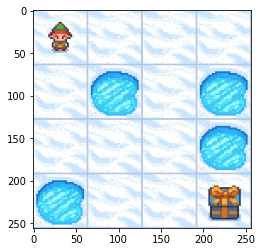

In [3]:
#Initialize environment from gym.  Env must be reset upon inital environment creation.  
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True, new_step_api=True)
state = env.reset()
print(state)
screen = env.render(mode='rgb_array')

plt.imshow(screen);

## Model

In [26]:
#Creat a QLearning class to compile various environment and learning functions
class QLearningAgent():
    def __init__(self, desc, map_name, is_slippery, lr, df, ep, ep_min, pr):
        self.env = gym.make("FrozenLake-v1", desc=desc, map_name=map_name, is_slippery=is_slippery)
        self.done = False
        #Qtable will initally be set to zero
        self.q_table = np.zeros([self.getObservationSpaceSize(), self.getNumActions()], dtype=float)
        #The following are hyperparameters that can be optimized
        self.learning_rate = lr  
        self.discount_factor = df
        self.max_episodes = 1000
        self.max_iterations_per_episode = 100
        self.epsilon = ep
        self.epsilon_min = ep_min
        self.epsilon_decay_rate = (self.epsilon - self.epsilon_min) / self.max_episodes
        self.print_results = pr
    
    #The first 7 functions are wrappers for the environment
    def reset(self):
        return self.env.reset()
        
    def close(self):
        self.env.close()
        
    def render(self, mode='rgb_array'):
        return self.env.render(mode)
    
    def getNumActions(self):
        return self.env.action_space.n
    
    def getActions(self):
        num_actions = self.getNumActions()
        return list(range(0, num_actions))
    
    def getObservationSpace(self):
        return self.env.observation_space
    
    def getObservationSpaceSize(self):
        return self.env.observation_space.n
    
    #Use epsilon greedy method to select an action.  Note that epsilon is decayed at a
    #set rate in the funciton just below.
    def actionChoice(self, state):
        epsilon_test = random.random()
        if epsilon_test > self.epsilon:
            action = np.argmax(self.q_table[state,:])
        else:
            action = random.choice(self.getActions())
        return action
    
    #This is a linear decay rate, so there will still be exploration into later episodes.
    def decayEpsilon(self):
        self.epsilon = self.epsilon - self.epsilon_decay_rate
    
    #Take an action in the environment and update the Q-table.  Rewards are only given
    #if the agent finds the goal state.
    def takeAction(self, state, action):
        next_state, reward, done, info = self.env.step(action)
        
        self.q_table[state, action] = (1 - self.learning_rate) * self.q_table[state, action] + \
                                      self.learning_rate * ((reward) + self.discount_factor * \
                                      np.max(self.q_table[next_state, :]))
        
        return next_state, reward, done
    
    #Function to train the agent.  Keeps a tally of the total rewards per episode as
    #well as the number of episodes completed.
    def trainAgent(self):
        total_rewards = []
        episode = 0
        episode_list = []
        for episode in range(self.max_episodes):
            current_state = self.reset() #Get the intial state
            done = False
            
            reward_for_episode = 0
            
            episode += 1
            episode_list.append(episode)
            
            #Loop through training iterations, selecting an action, updating the Q-table,
            #tracking the reward, and break from loop if episode has ended
            for iteration in range(self.max_iterations_per_episode):
                action = self.actionChoice(current_state)
                
                current_state, reward, done = self.takeAction(current_state, action)

                reward_for_episode += reward

                if done == True:
                    break
            
            #Track reward for episode and decay epsilon
            total_rewards.append(reward_for_episode)
            
            self.decayEpsilon()

        if self.print_results == True:
            self.printTrainingExperience(episode_list, total_rewards)

        #return the average reward per episode
        return np.average(total_rewards)
    
    #Function to print the results from training for this round of episodes
    def printTrainingExperience(self, episodes, rewards):
        plt.figure(figsize=(4,4))
        plt.title("Reward Per Episode - QLearning Agent")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.plot(episodes, rewards)
     
    #Helper function to test the Agent once trained.
    #Runs through episidoes and prints the success rate.
    def testAgent(self):
        reward_cnt = 0
        for episode in range(self.max_episodes):
            current_state = self.reset()
            done = False
            for iteration in range(self.max_iterations_per_episode):
                action = np.argmax(self.q_table[current_state,:])
                current_state, reward, done, info = self.env.step(action)
                reward_cnt += reward
                if done:
                    break
                    
        return (reward_cnt / self.max_episodes)
        
    def printPolicy(self, holes):
        arrows = {0:(-1, 0), 1:(0, -1), 2:(1,0), 3:(0,1), None:(0,0)}
        scale = 0.25
        policy = []
        cnt = 0
        row = []
        for state in range(self.getObservationSpaceSize()):
            if state in holes:
                action = None
            else:
                action = np.argmax(self.q_table[state,:])
            row.append(action)
            cnt += 1
            if cnt % 4 == 0:
                policy.append(row)
                row = []
        fig ,ax = plt.subplots(figsize=(4,4))
        for r, row in enumerate(policy):
            for c, cell in enumerate(row):
                plt.arrow(c, 4-r, scale * arrows[cell][0], scale * arrows[cell][1], head_width=0.1)
        plt.show()
        screen = self.render()
        plt.imshow(screen)

## Results

I will first try the Q-Learning algorithm on a non-slippery, "4x4" environment, tracking the average reward across episodes.

In [5]:
#Helper function to print success rate
def printReward(rwd):
    print(f"Success Rate of: {(rwd):.0%}")

In [6]:
#Helper function to pack inputs to class and only change the ones under investigation
def packInputs(desc=None, in_map="4x4", slippery=True, lr=0.9, dr=0.5, ep=0.90, ep_min=.01, pr=False):
    self_desc = desc
    self_in_map = in_map
    self_slippery = slippery
    self_lr = lr
    self_dr = dr
    self_ep = ep
    self_ep_min = ep_min
    self_pr = pr
    
    return [self_desc, self_in_map, self_slippery, self_lr, self_dr, self_ep, self_ep_min, self_pr]

The average reward / per episode for a non-slippery, 4x4 env. is:  0.48


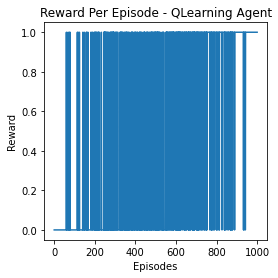

In [8]:
#Pack inputs, pass to Agent Class, and print results
inputs = packInputs(slippery=False, pr=True)

env = QLearningAgent(*inputs)
result = env.trainAgent()
print('The average reward / per episode for a non-slippery, 4x4 env. is: ', result)

We can see that it took some time for the agent to discover the correct path that maximized its rewards.  Even after the agent has discovered this path, the agent is still operating on the epsilon greedy selection strategy and therefore continues to explore different paths along each training episode.

A gif of the first 100 traning episodes is shown below.

<img src="nonslip.gif" width="275" align="left">

To ensure the agent truly has learned the optimal policy, I will run 1,000 test episodes.  We can see that the agent indeed does receive the reward with a 100% success rate.

In [9]:
result = env.testAgent()
printReward(result)

Success Rate of: 100%


Printing out the policy (no arrow line indicates hole or goal state) shows that that agent simply navigates around the holes to get to the goal state.  As each action is deterministic, this makes sense.

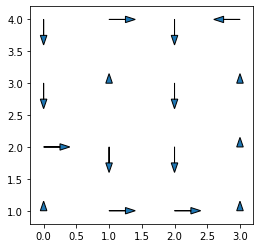

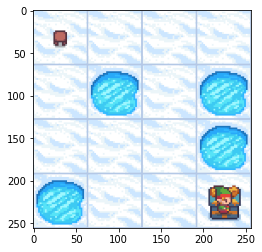

In [10]:
holes = (5, 7, 11, 12, 15)
env.printPolicy(holes)

I will now see how my agent performs on a slippery, "4x4" grid.

The average reward / per episode for a slippery, 4x4 env. is:  0.03


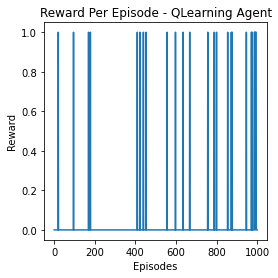

In [18]:
#Pack inputs, pass to Agent class [slippery == True], and print outputs
inputs = packInputs(slippery=True, pr=True)

env = QLearningAgent(*inputs)
result = env.trainAgent()
print('The average reward / per episode for a slippery, 4x4 env. is: ', result)

We can see that the agent does much worse in this stochastic environment.  It can be seen that the agent perfroms much worse, only reaching the goal state less than 10% of the time, on average. The question is how can I improve this performance in such as a stochastic environment?

A gif of the slipper traninig environment is shown below.

<img src="slip.gif" width="275" align="left">

Testing this agent, we can see that the performance has significantly dropped.  While the agent will never reach the goal state 100% of the time in a stochastic environment, the question is how can I improve this result?

In [19]:
result = env.testAgent()
printReward(result)

Success Rate of: 16%


Printing out this policy, we can see some interesting things.  The agent simply avoids the hole by taking the action opposite to the hole.  With no time penalty, the agent has an infinite amount of time to traverse the grid and make it the goal state.

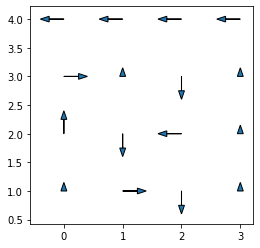

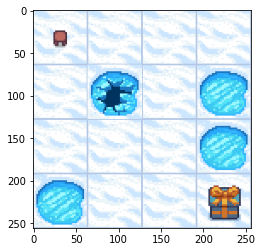

In [20]:
holes = (5, 7, 11, 12, 15)
env.printPolicy(holes)

I will first investigate the effects of changing the learning rate.  Here, I will

In [21]:
#Helper function ot print results of given parameter under investigation
def graphResults(xrange, yrange, title, xaxis):
    plt.figure(figsize=(4,4))
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel("Reward")
    plt.plot(xrange, yrange);

Max results achieved at a Learning Rate of:  0.8


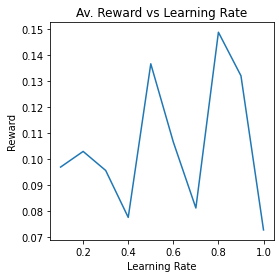

In [28]:
#Create a range on numbers for the learning rate, pack inputs, and compute average reward
lr_range = np.arange(.1, 1.1, .1)

final_results = np.zeros(10)

#Loop through lr range to find optimal one
for i in range(10):
    trial_results = []
    for num in lr_range:
        inputs = packInputs(lr=num)
        env = QLearningAgent(*inputs)
        env.trainAgent()
        ret = env.testAgent()
        trial_results.append(ret)
    final_results = np.add(final_results, trial_results)
final_results = np.divide(final_results, 10.0)

title = "Av. Reward vs Learning Rate"
xaxis = "Learning Rate"

graphResults(lr_range, final_results, title, xaxis)

max_lr = lr_range[np.argmax(final_results)]
print('Max results achieved at a Learning Rate of: ', max_lr)

Max results achieved at a Discount Rate of:  0.9


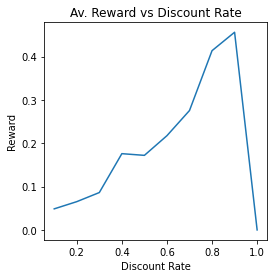

In [29]:
#Create a range on numbers for the discount rate, pack inputs, and compute average reward
dr_range = np.arange(.1, 1.1, .1)

final_results = np.zeros(10)

#Loop through dr range 10 times to find optimal average
for i in range(10):
    trial_results = []
    for num in dr_range: 
        inputs = packInputs(dr = num)
        env = QLearningAgent(*inputs)
        env.trainAgent()
        ret = env.testAgent()
        trial_results.append(ret)
    final_results = np.add(final_results, trial_results)
final_results = np.divide(final_results, 10.0)

title = "Av. Reward vs Discount Rate"
xaxis = "Discount Rate"

graphResults(dr_range, final_results, title, xaxis)

max_dr = dr_range[np.argmax(final_results)]
print('Max results achieved at a Discount Rate of: ', max_dr)

Max results achieved at Epsilon of:  0.9


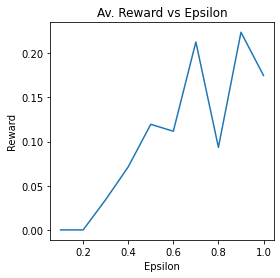

In [30]:
#Create a range on numbers for the discount rate, pack inputs, and compute average reward
ep_range = np.arange(.1, 1.1, .1)

final_results = np.zeros(10)

#Loop through dr range 10 times to find optimal average
for i in range(10):
    trial_results = []
    for num in dr_range: 
        inputs = packInputs(ep = num)
        env = QLearningAgent(*inputs)
        env.trainAgent()
        ret = env.testAgent()
        trial_results.append(ret)
    final_results = np.add(final_results, trial_results)
final_results = np.divide(final_results, 10.0)

title = "Av. Reward vs Epsilon"
xaxis = "Epsilon"

graphResults(ep_range, final_results, title, xaxis)

max_ep = ep_range[np.argmax(final_results)]
print('Max results achieved at Epsilon of: ', max_ep)

The average reward / per episode for a slippery, 4x4 env. is:  0.043


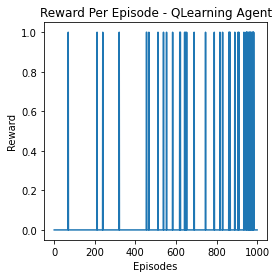

In [31]:
#Pack inputs, pass to Agent class [slippery == True], and print outputs
inputs = packInputs(slippery=True, pr=True, ep=max_ep, lr=max_lr, dr=max_dr)

env = QLearningAgent(*inputs)
result = env.trainAgent()
print('The average reward / per episode for a slippery, 4x4 env. is: ', result)

We can see that tuning the parameters has led to a significant increase in success rate for the stochastic environment.

In [34]:
result = env.testAgent()
printReward(result)

Success Rate of: 54%


It's interesting to note that the policy now has the agent going towards the hole for a number of states.  The probabilty that the action taken is the action observed is only 33.33%, therefore it may be smarter to head toward the hole, knowing that the agent will likely end up in another state.

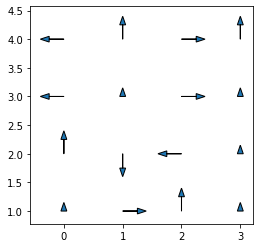

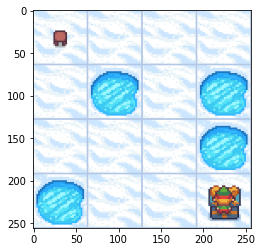

In [35]:
holes = (5, 7, 11, 12, 15)
env.printPolicy(holes)

I will now try my algorithm on the 8x8 grid.  I suspect that the agent will take longer to reach the goal state and performance will degrade.  Also note, in order to train this agent I had to set epsidoes to 10,000, which I set back in my class afterwards.  It took many episodes as the agent had to randomly select an action sequence to get to the reward state to start learning.

The average reward / per episode for a non-slippery, 8x8 env. is:  0.0645
Success Rate of: 8%


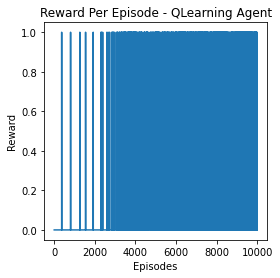

In [347]:
inputs = packInputs(in_map="8x8", slippery=True, pr=True, ep=max_ep, lr=max_lr, dr=max_dr)

env = QLearningAgent(*inputs)
result = env.trainAgent()
print('The average reward / per episode for a non-slippery, 8x8 env. is: ', result)
env.testAgent()

## Conclusion

Q-Learning is the optimal strategy to use on a stochastic environment with a small state space.  It was shown that tuning hyperparameters can lead to better algorithm performance.  A low learning rate, a high discount rate, and an even split between exploration and exploitation produced that best results for this particular environment. The 8x8 grid required much more training episodes as the agent had a far more likely time falling into holes, thus extending learning by the sparse rewards. This alorithm could be improved, as far as performance goes, by including some kind of immediate reward to let the agent know it is on the right path.

However, as the state space increases, Q-Learning can quickly become inefficient, with performance degrading rapidly.  The Q-Table would become too large to store in memory, and alternative algorithms must be used.  Deep Q-Learning can hep to bridge this gap and it would be intersting to perfrom this simulation utilizing the Deep Q-Learning Algorithm.

## References

1.) https://towardsdatascience.com/q-learning-for-beginners-2837b777741 - Used a a refresher for Q-Learning and an introduction to OpenAI Gym.